In [1]:
%matplotlib inline

In [2]:
import zipfile
# This is used to load models train on kaggle
with zipfile.ZipFile("../data/models/unet-ssim-loss.zip", 'r') as zip_ref:
   zip_ref.extractall("../data/models")

In [3]:
from src.ptp.globals import TARGET_DATA_DIR, TRAINING_DIR
import torch
import nibabel as nib  
from monai.data import MetaTensor
from src.ptp.models.u_net.u_net import Net
import pytorch_lightning as pl 

from src.ptp.evaluation.visualization import visualize_slices, visualize_volumes
from src.ptp.models.transforms import CorruptedTransform, rescale_volume
from src.ptp.utils import training_data_generator

import numpy as np
import os

In [4]:
corrupted_tf = CorruptedTransform(10, keys=['target'])

target_file = os.listdir(TARGET_DATA_DIR)[0]
target = nib.load(TARGET_DATA_DIR / target_file).get_fdata()

target = MetaTensor(torch.unsqueeze(torch.Tensor(target), 0))
print(target.shape)

data = corrupted_tf({'target': target})

torch.Size([1, 300, 300, 1259])


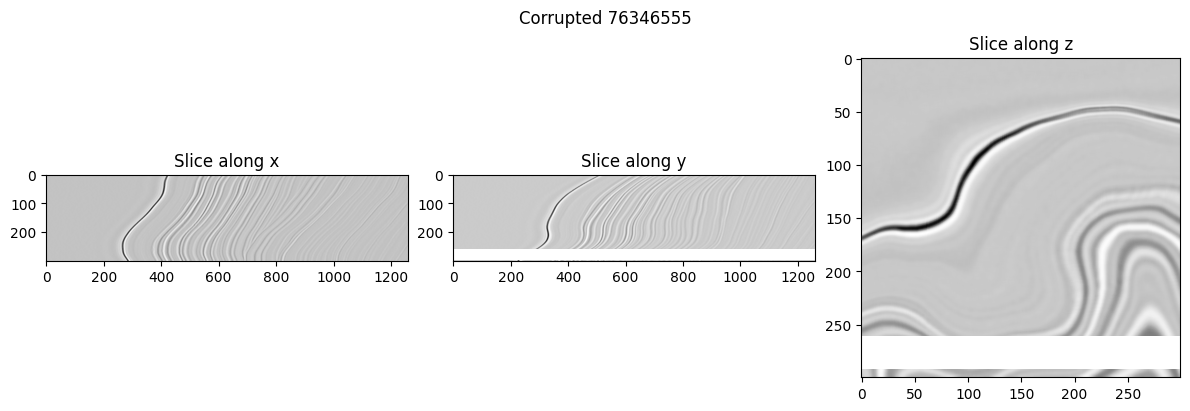

In [5]:
visualize_slices(nib.Nifti1Image(data['image'].as_tensor().numpy()[0], np.eye(4)), 150, 150, 400, f'Corrupted {target_file.split(".")[-2]}')

Oryginalne zdjęcia są przeskalowane do zakresu 0-1

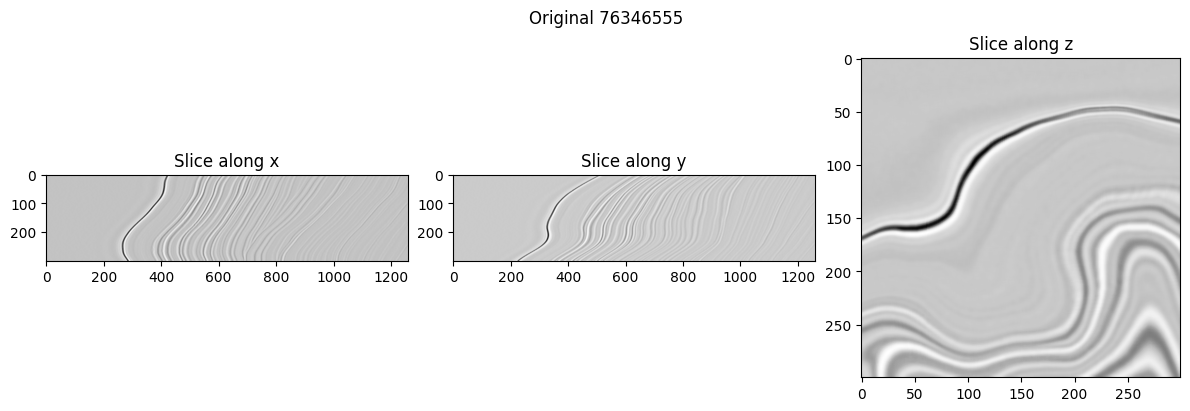

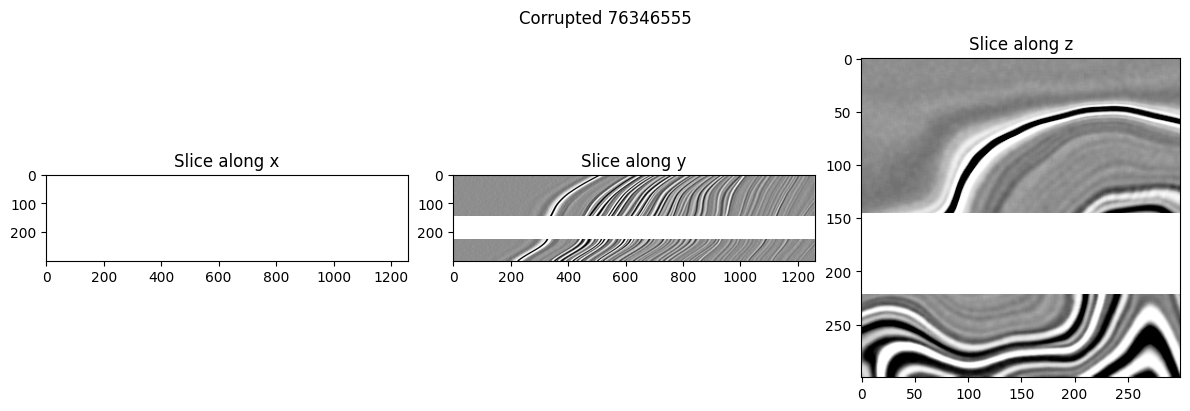

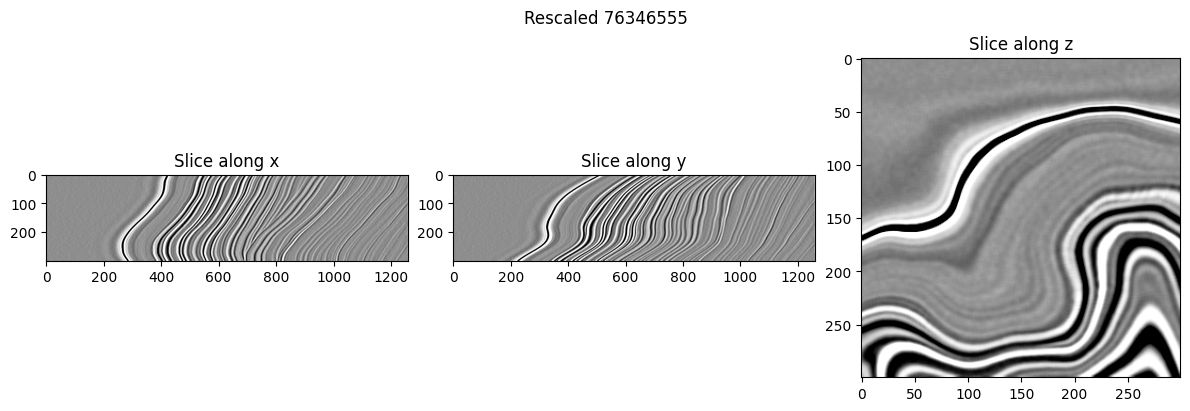

In [6]:
target_file = os.listdir(TARGET_DATA_DIR)[0]
target = nib.load(TARGET_DATA_DIR / target_file)
visualize_slices(target, 150, 150, 400, f'Original {target_file.split(".")[-2]}')
img, _, _ = training_data_generator(target.get_fdata())
target = rescale_volume(target.get_fdata())
visualize_slices(nib.Nifti1Image(img, np.eye(4)), 150, 150, 400, f'Corrupted {target_file.split(".")[-2]}')
visualize_slices(nib.Nifti1Image(target, np.eye(4)), 150, 150, 400, f'Rescaled {target_file.split(".")[-2]}')

#### Problemy
1. Cały wolumin nie mieści się w pamięci
2. U-Net zakłada, że rozmiary są wielkości wielokrotności potęgi 2.

https://github.com/Project-MONAI/tutorials/blob/main/modules/UNet_input_size_constraints.ipynb

In [7]:
from torchmetrics.functional.image import structural_similarity_index_measure

def ssim_loss(preds, target):
    return 1 - structural_similarity_index_measure(preds, target, data_range=1.0)

In [9]:
percentile = 5

#### Predykcje ze stratą MSE
Model był trenowany testowo na jednej próbce

In [10]:
os.listdir(TRAINING_DIR / 'unet-8-mse')

['epoch=0-val_loss=0.27-train_loss=0.96.ckpt',
 'epoch=0-val_loss=0.36-train_loss=1.11.ckpt',
 'epoch=0-val_loss=0.38-train_loss=0.96.ckpt',
 'epoch=5-val_loss=0.18-train_loss=0.38.ckpt',
 'epoch=6-val_loss=0.16-train_loss=0.24.ckpt',
 'epoch=9-val_loss=0.16-train_loss=0.26.ckpt',
 'last-v1.ckpt',
 'last-v2.ckpt',
 'last-v3.ckpt',
 'last-v4.ckpt',
 'last.ckpt',
 'lightning_logs']

In [12]:
net = Net.load_from_checkpoint(TRAINING_DIR / 'unet-8-mse/epoch=9-val_loss=0.16-train_loss=0.26.ckpt', percentile=percentile, target_data_dir = TARGET_DATA_DIR, one_sample_mode=True)

net.eval()
net.prepare_data()
val_loader = net.val_dataloader()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


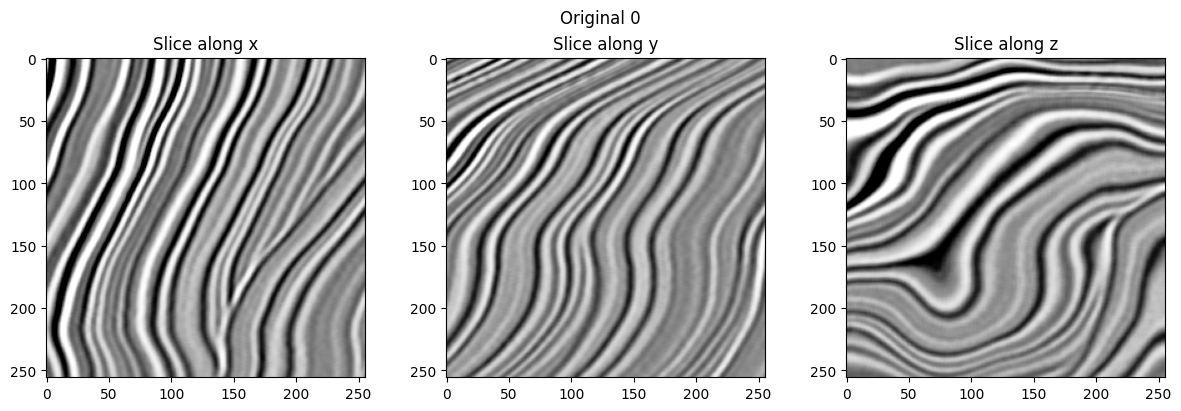

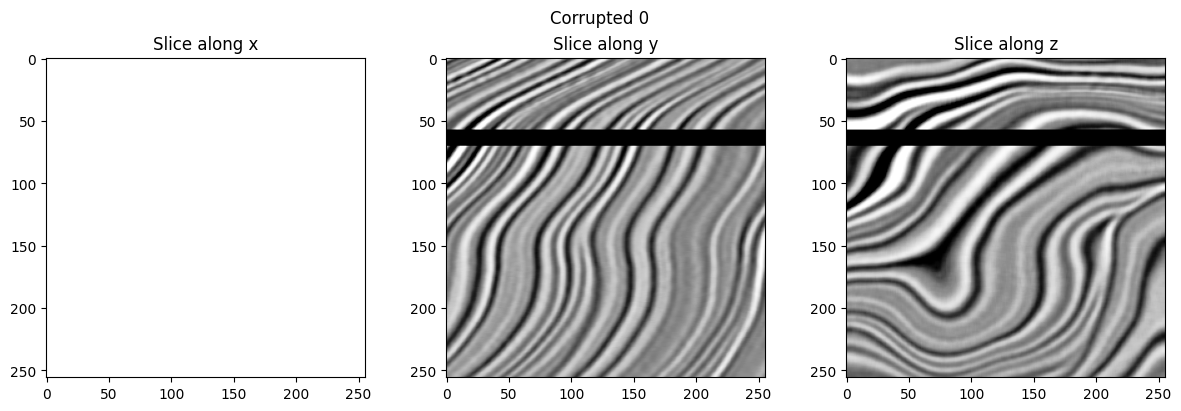

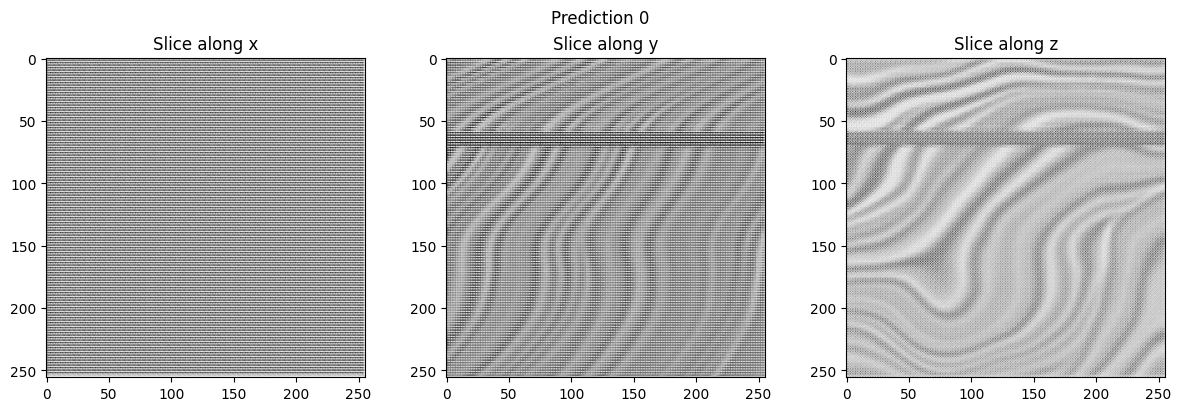

In [14]:
keys = ['target','image', 'prediction']
labels = ['Original','Corrupted', 'Prediction']

trainer = pl.Trainer()

for i, batch in enumerate(val_loader):
    prediction = net(batch['image'])
    batch['prediction'] = prediction
    visualize_volumes(batch, i, keys, labels, True)

#### Predykcje ze stratą SSIM

Model był trenowany testowo na jednej próbce

In [39]:
os.listdir(TRAINING_DIR / 'unet-8-ssim')

['epoch=4-val_loss=0.98-train_loss=0.94.ckpt', 'last.ckpt', 'lightning_logs']

In [41]:
net = Net.load_from_checkpoint(TRAINING_DIR / 'unet-8-ssim/epoch=4-val_loss=0.98-train_loss=0.94.ckpt', 
                               target_data_dir=TARGET_DATA_DIR, percentile=percentile)

net.eval()
net.prepare_data()
val_loader = net.val_dataloader()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


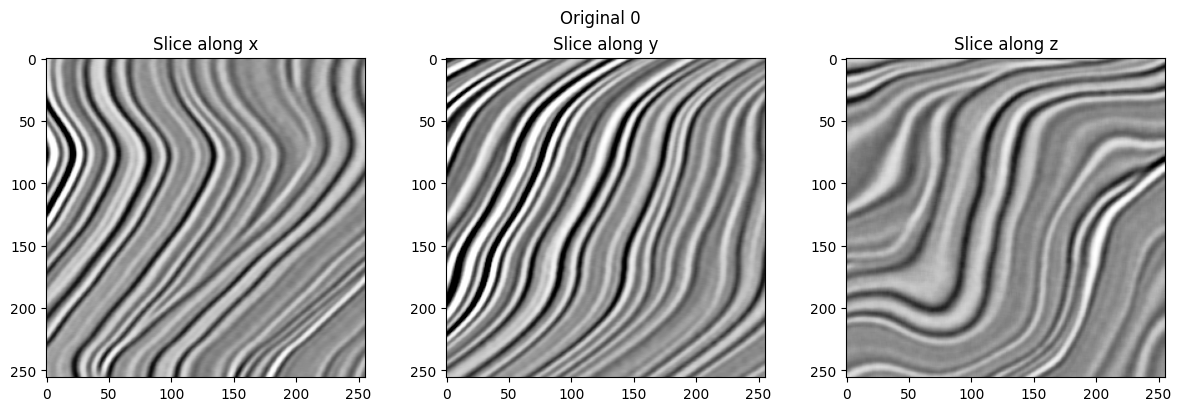

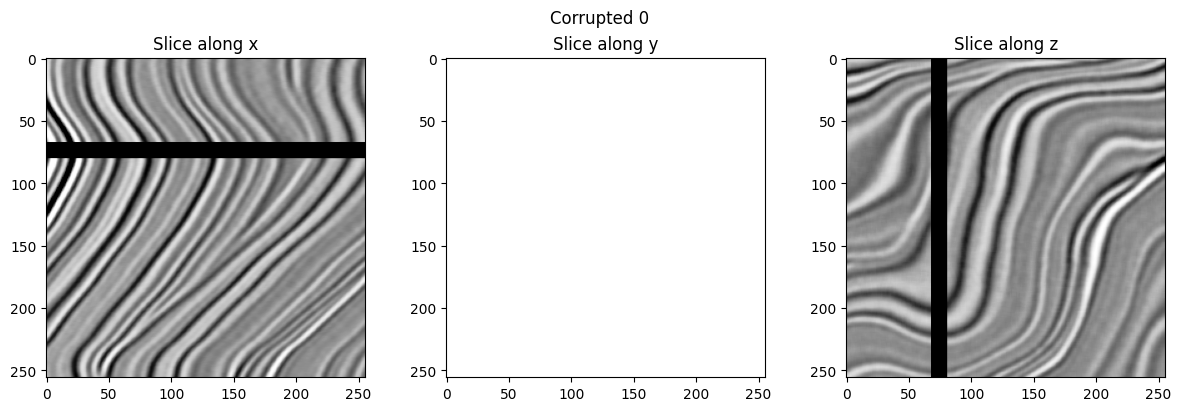

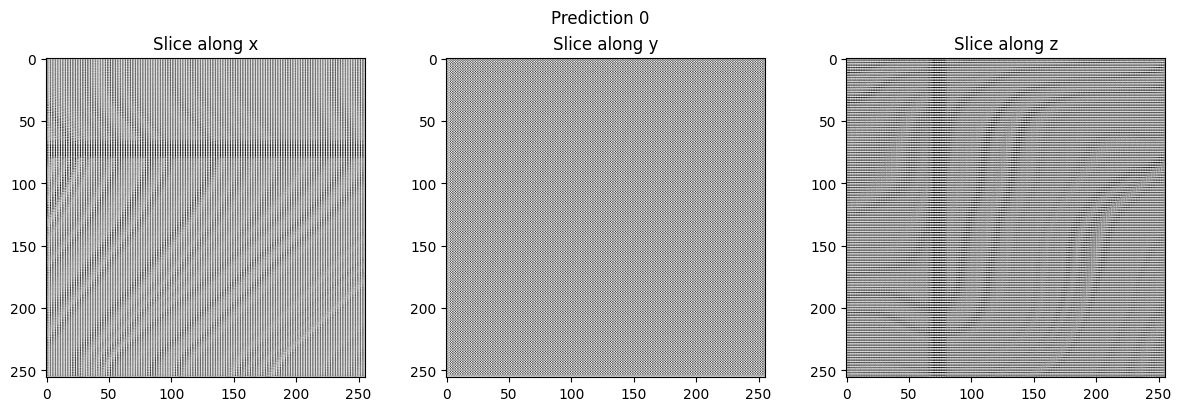

In [42]:
keys = ['target','image', 'prediction']
labels = ['Original','Corrupted', 'Prediction']

trainer = pl.Trainer()

for i, batch in enumerate(val_loader):
    prediction = net(batch['image'])
    batch['prediction'] = prediction
    visualize_volumes(batch, i, keys, labels, True)